# House Prices - Advanced Regression Techniques
## Model Experiment Notebook

This notebook implements a comprehensive machine learning pipeline for the House Prices prediction competition, including:
- Data exploration and cleaning
- Feature engineering and selection
- Model training and evaluation
- Hyperparameter optimization
- MLflow experiment tracking

## 1. Initial Setup and Data Loading

In [1]:
# Install required packages
%pip install -q dagshub mlflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_regression, RFE, SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import mlflow.sklearn
import warnings
warnings.filterwarnings('ignore')

In [3]:
# MLflow Setup - DagHub connection
os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow'
os.environ['MLFLOW_TRACKING_USERNAME'] = 'g-kitiashvili'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '1c2227158cc19daf66bb3b241116a8e8c5f1cd20' 
mlflow.set_experiment(f"house-prices-experiments")

<Experiment: artifact_location='mlflow-artifacts:/e6f9a36462414578ab938223b4d1196d', creation_time=1750758231329, experiment_id='0', last_update_time=1750758231329, lifecycle_stage='active', name='house-prices-experiments', tags={}>

In [4]:
# Load data
train_data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (1460, 81)
Test data shape: (1459, 80)


In [5]:
# Basic info about the data
print("Training data info:")
print(train_data.info())
print("\nTarget variable statistics:")
print(train_data['SalePrice'].describe())

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   i

## 2. Data Exploration and Analysis

Missing values:
              Missing Count  Percentage
PoolQC                 1453   99.520548
MiscFeature            1406   96.301370
Alley                  1369   93.767123
Fence                  1179   80.753425
MasVnrType              872   59.726027
FireplaceQu             690   47.260274
LotFrontage             259   17.739726
GarageQual               81    5.547945
GarageFinish             81    5.547945
GarageType               81    5.547945
GarageYrBlt              81    5.547945
GarageCond               81    5.547945
BsmtFinType2             38    2.602740
BsmtExposure             38    2.602740
BsmtCond                 37    2.534247
BsmtQual                 37    2.534247
BsmtFinType1             37    2.534247
MasVnrArea                8    0.547945
Electrical                1    0.068493


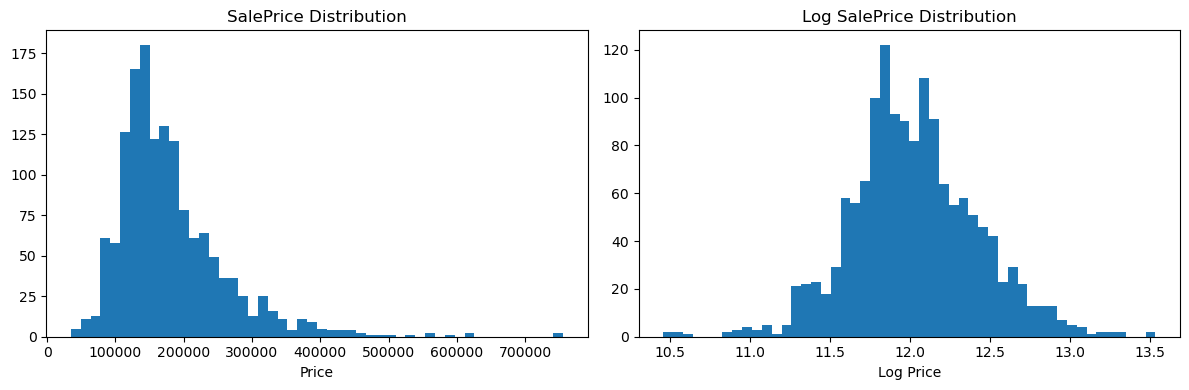


Top correlations with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64
🏃 View run EDA at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/a4a20c0f03d345bd86a15f5a33500f86
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


In [6]:
# Start MLflow run for EDA
with mlflow.start_run(run_name="EDA"):
    # Log dataset info
    mlflow.log_param("train_shape", train_data.shape)
    mlflow.log_param("test_shape", test_data.shape)
    
    # Missing values analysis
    missing_data = train_data.isnull().sum().sort_values(ascending=False)
    missing_percent = (missing_data / len(train_data)) * 100
    missing_df = pd.DataFrame({'Missing Count': missing_data, 'Percentage': missing_percent})
    missing_df = missing_df[missing_df['Missing Count'] > 0]
    
    print("Missing values:")
    print(missing_df.head(20))
    
    mlflow.log_metric("missing_features_count", len(missing_df))
    # Target variable distribution
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(train_data['SalePrice'], bins=50)
    plt.title('SalePrice Distribution')
    plt.xlabel('Price')
    
    plt.subplot(1, 2, 2)
    plt.hist(np.log(train_data['SalePrice']), bins=50)
    plt.title('Log SalePrice Distribution')
    plt.xlabel('Log Price')
    plt.tight_layout()
    plt.savefig('target_distribution.png')
    mlflow.log_artifact('target_distribution.png')
    plt.show()
    
     # Correlation with target
    numeric_features = train_data.select_dtypes(include=[np.number]).columns
    correlations = train_data[numeric_features].corr()['SalePrice'].sort_values(ascending=False)
    print("\nTop correlations with SalePrice:")
    print(correlations.head(15))
    
    mlflow.log_metric("numeric_features_count", len(numeric_features))

## 3. Data Cleaning

In [7]:
def clean_data(df, is_train=True):
    """
    Data cleaning function
    """
    df_clean = df.copy()
    
    # Remove outliers (only for training data)
    if is_train:
        # Remove extreme outliers based on GrLivArea and SalePrice
        df_clean = df_clean.drop(df_clean[(df_clean['GrLivArea'] > 4000) & 
                                         (df_clean['SalePrice'] < 300000)].index)
    
    # Handle missing values for specific features
    # Categorical features with meaningful NA
    categorical_na_features = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                              'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
                              'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                              'PoolQC', 'Fence', 'MiscFeature']
    
    for feature in categorical_na_features:
        if feature in df_clean.columns:
            df_clean[feature] = df_clean[feature].fillna('None')
    
    # Numerical features with meaningful zero
    numerical_zero_features = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                              'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
                              'GarageArea', 'GarageCars', 'MasVnrArea']
    
    for feature in numerical_zero_features:
        if feature in df_clean.columns:
            df_clean[feature] = df_clean[feature].fillna(0)
    
    # Other categorical features - fill with mode
    categorical_features = df_clean.select_dtypes(include=['object']).columns
    for feature in categorical_features:
        if df_clean[feature].isnull().any():
            mode_value = df_clean[feature].mode()[0] if len(df_clean[feature].mode()) > 0 else 'Unknown'
            df_clean[feature] = df_clean[feature].fillna(mode_value)
    
    # Numerical features - fill with median
    numerical_features = df_clean.select_dtypes(include=[np.number]).columns
    for feature in numerical_features:
        if df_clean[feature].isnull().any():
            median_value = df_clean[feature].median()
            df_clean[feature] = df_clean[feature].fillna(median_value)
    
    return df_clean

In [8]:
# Apply cleaning
with mlflow.start_run(run_name="Data_Cleaning"):
    train_clean = clean_data(train_data, is_train=True)
    test_clean = clean_data(test_data, is_train=False)
    
    print(f"Original training data shape: {train_data.shape}")
    print(f"Cleaned training data shape: {train_clean.shape}")
    
    # Log cleaning results
    mlflow.log_param("original_train_shape", train_data.shape)
    mlflow.log_param("cleaned_train_shape", train_clean.shape)
    mlflow.log_param("outliers_removed", train_data.shape[0] - train_clean.shape[0])
    
    # Check remaining missing values
    missing_after = train_clean.isnull().sum().sum()
    print(f"Missing values after cleaning: {missing_after}")
    mlflow.log_metric("missing_values_after_cleaning", missing_after)

Original training data shape: (1460, 81)
Cleaned training data shape: (1458, 81)
Missing values after cleaning: 0
🏃 View run Data_Cleaning at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/587c1b498b194a3294229dee104a3ae8
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


## 4. Feature Engineering

In [9]:
def feature_engineering(df):
    """
    Create new features and transform existing ones
    """
    df_fe = df.copy()
    
    # Create new features
    df_fe['TotalSF'] = df_fe['TotalBsmtSF'] + df_fe['1stFlrSF'] + df_fe['2ndFlrSF']
    df_fe['Total_Bathrooms'] = (df_fe['FullBath'] + (0.5 * df_fe['HalfBath']) +
                               df_fe['BsmtFullBath'] + (0.5 * df_fe['BsmtHalfBath']))
    df_fe['Total_porch_sf'] = (df_fe['OpenPorchSF'] + df_fe['3SsnPorch'] +
                              df_fe['EnclosedPorch'] + df_fe['ScreenPorch'] +
                              df_fe['WoodDeckSF'])
    
    # Age of house
    df_fe['HouseAge'] = df_fe['YrSold'] - df_fe['YearBuilt']
    df_fe['RemodAge'] = df_fe['YrSold'] - df_fe['YearRemodAdd']
    
    # Garage age
    df_fe['GarageAge'] = df_fe['YrSold'] - df_fe['GarageYrBlt']
    df_fe['GarageAge'] = df_fe['GarageAge'].fillna(0)
    
    # Has features
    df_fe['HasBasement'] = (df_fe['TotalBsmtSF'] > 0).astype(int)
    df_fe['HasGarage'] = (df_fe['GarageArea'] > 0).astype(int)
    df_fe['HasFireplace'] = (df_fe['Fireplaces'] > 0).astype(int)
    df_fe['HasPool'] = (df_fe['PoolArea'] > 0).astype(int)
    
    # Price per square foot proxies
    df_fe['Price_per_sqft_total'] = df_fe['TotalSF']
    df_fe['Price_per_sqft_living'] = df_fe['GrLivArea']
    
    return df_fe

In [10]:
# Apply feature engineering
with mlflow.start_run(run_name="Feature_Engineering"):
    train_fe = feature_engineering(train_clean)
    test_fe = feature_engineering(test_clean)
    
    print(f"Shape after feature engineering: {train_fe.shape}")
    
    # Log feature engineering results
    mlflow.log_param("features_after_engineering", train_fe.shape[1])
    mlflow.log_param("new_features_created", train_fe.shape[1] - train_clean.shape[1])
    
    # Show new features
    new_features = set(train_fe.columns) - set(train_clean.columns)
    print(f"New features created: {new_features}")
    mlflow.log_param("new_features_list", list(new_features))

Shape after feature engineering: (1458, 93)
New features created: {'Price_per_sqft_living', 'Total_Bathrooms', 'RemodAge', 'HasBasement', 'HouseAge', 'HasPool', 'HasGarage', 'HasFireplace', 'GarageAge', 'Total_porch_sf', 'Price_per_sqft_total', 'TotalSF'}
🏃 View run Feature_Engineering at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/ef9e4711d8e541e49bb31958a36080c8
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


## 5. Feature Encoding

In [11]:
def encode_features(train_df, test_df, target_col='SalePrice'):
    """
    Encode categorical features
    """
    # Separate features and target
    if target_col in train_df.columns:
        X_train = train_df.drop(columns=[target_col])
        y_train = train_df[target_col]
    else:
        X_train = train_df.copy()
        y_train = None
    
    X_test = test_df.copy()
    
    # Get categorical and numerical features
    categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
    numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove ID column if present
    if 'Id' in numerical_features:
        numerical_features.remove('Id')
        X_train = X_train.drop('Id', axis=1)
        X_test = X_test.drop('Id', axis=1)
    
    # One-hot encoding for categorical features
    X_train_encoded = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)
    
    # Align columns between train and test
    missing_cols_test = set(X_train_encoded.columns) - set(X_test_encoded.columns)
    missing_cols_train = set(X_test_encoded.columns) - set(X_train_encoded.columns)
    
    # Add missing columns to test set
    for col in missing_cols_test:
        X_test_encoded[col] = 0
    
    # Add missing columns to train set
    for col in missing_cols_train:
        X_train_encoded[col] = 0
    
    # Reorder columns
    X_test_encoded = X_test_encoded[X_train_encoded.columns]
    
    return X_train_encoded, X_test_encoded, y_train

In [12]:
# Apply encoding
with mlflow.start_run(run_name="Feature_Encoding"):
    X_train_encoded, X_test_encoded, y_train = encode_features(train_fe, test_fe)
    
    print(f"Encoded training features shape: {X_train_encoded.shape}")
    print(f"Encoded test features shape: {X_test_encoded.shape}")
    
    mlflow.log_param("encoded_features_count", X_train_encoded.shape[1])
    mlflow.log_param("train_samples", X_train_encoded.shape[0])

Encoded training features shape: (1458, 269)
Encoded test features shape: (1459, 269)
🏃 View run Feature_Encoding at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/416cd0c509d9451c90b898284a3b38a0
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


## 6. Feature Selection

In [13]:
def perform_feature_selection(X_train, y_train, method='all'):
    """
    Perform feature selection using different methods
    """
    results = {}
    
    if method == 'univariate' or method == 'all':
        # Univariate feature selection
        selector_univariate = SelectKBest(score_func=f_regression, k=50)
        X_train_univariate = selector_univariate.fit_transform(X_train, y_train)
        selected_features_univariate = X_train.columns[selector_univariate.get_support()].tolist()
        results['univariate'] = {
            'selector': selector_univariate,
            'features': selected_features_univariate,
            'X_transformed': X_train_univariate
        }
    
    if method == 'rfe' or method == 'all':
        # Recursive Feature Elimination
        estimator = RandomForestRegressor(n_estimators=50, random_state=42)
        selector_rfe = RFE(estimator, n_features_to_select=50)
        X_train_rfe = selector_rfe.fit_transform(X_train, y_train)
        selected_features_rfe = X_train.columns[selector_rfe.get_support()].tolist()
        results['rfe'] = {
            'selector': selector_rfe,
            'features': selected_features_rfe,
            'X_transformed': X_train_rfe
        }
    
    if method == 'lasso' or method == 'all':
        # L1-based feature selection
        lasso = Lasso(alpha=0.01, random_state=42)
        selector_lasso = SelectFromModel(lasso)
        X_train_lasso = selector_lasso.fit_transform(X_train, y_train)
        selected_features_lasso = X_train.columns[selector_lasso.get_support()].tolist()
        results['lasso'] = {
            'selector': selector_lasso,
            'features': selected_features_lasso,
            'X_transformed': X_train_lasso
        }
    
    return results

In [14]:
# Perform feature selection experiments
feature_selection_methods = ['univariate', 'rfe', 'lasso']
selection_results = {}

for method in feature_selection_methods:
    with mlflow.start_run(run_name=f"Feature_Selection_{method}"):
        result = perform_feature_selection(X_train_encoded, y_train, method=method)
        selection_results[method] = result[method]
        
        print(f"\n{method.upper()} Feature Selection:")
        print(f"Selected {len(result[method]['features'])} features")
        
        mlflow.log_param("selection_method", method)
        mlflow.log_param("selected_features_count", len(result[method]['features']))
        mlflow.log_param("original_features_count", X_train_encoded.shape[1])


UNIVARIATE Feature Selection:
Selected 50 features
🏃 View run Feature_Selection_univariate at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/86f9bca1844f418698625934c22d5024
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0

RFE Feature Selection:
Selected 50 features
🏃 View run Feature_Selection_rfe at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/464717d64e6e41d48ae3ede9c311fe4c
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0

LASSO Feature Selection:
Selected 268 features
🏃 View run Feature_Selection_lasso at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/798a5f61a05a41e8b78f90eec8973700
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


## 7. Model Training and Evaluation

In [15]:
def evaluate_model(model, X_train, y_train, cv=5):
    """
    Evaluate model using cross-validation
    """
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                               scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    
    # Train on full training set for additional metrics
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    train_r2 = r2_score(y_train, y_pred)
    train_mae = mean_absolute_error(y_train, y_pred)
    
    return {
        'cv_rmse_mean': rmse_scores.mean(),
        'cv_rmse_std': rmse_scores.std(),
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'train_mae': train_mae,
        'fitted_model': model
    }

In [16]:
# Models to test
models = {
    'Linear_Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.01),
    'ElasticNet': ElasticNet(alpha=0.01),
    'Random_Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

In [17]:
# Test models with different feature selection methods
best_model_info = {'score': float('inf'), 'model': None, 'features': None, 'method': None}

for selection_method in ['univariate', 'rfe', 'lasso']:
    X_selected = selection_results[selection_method]['X_transformed']
    selected_features = selection_results[selection_method]['features']
    
    for model_name, model in models.items():
        with mlflow.start_run(run_name=f"{model_name}_{selection_method}"):
            try:
                # Evaluate model
                results = evaluate_model(model, X_selected, y_train)
                
                # Log parameters
                mlflow.log_param("model_type", model_name)
                mlflow.log_param("feature_selection", selection_method)
                mlflow.log_param("n_features", len(selected_features))
                
                # Log metrics
                mlflow.log_metric("cv_rmse_mean", results['cv_rmse_mean'])
                mlflow.log_metric("cv_rmse_std", results['cv_rmse_std'])
                mlflow.log_metric("train_rmse", results['train_rmse'])
                mlflow.log_metric("train_r2", results['train_r2'])
                mlflow.log_metric("train_mae", results['train_mae'])
                
                # Log model
                mlflow.sklearn.log_model(results['fitted_model'], f"model_{model_name}")
                
                print(f"{model_name} with {selection_method}: CV RMSE = {results['cv_rmse_mean']:.4f} (+/- {results['cv_rmse_std']:.4f})")
                
                # Track best model
                if results['cv_rmse_mean'] < best_model_info['score']:
                    best_model_info = {
                        'score': results['cv_rmse_mean'],
                        'model': results['fitted_model'],
                        'features': selected_features,
                        'method': selection_method,
                        'model_name': model_name
                    }
                    
            except Exception as e:
                print(f"Error with {model_name} and {selection_method}: {e}")

print(f"\nBest model: {best_model_info['model_name']} with {best_model_info['method']} selection")
print(f"Best CV RMSE: {best_model_info['score']:.4f}")

2025/06/24 16:31:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Linear_Regression with univariate: CV RMSE = 28377.5344 (+/- 2077.4570)
🏃 View run Linear_Regression_univariate at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/cb09790933fc41a0b856cb47e628d5ff
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


2025/06/24 16:32:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Ridge with univariate: CV RMSE = 28267.0337 (+/- 2048.7898)
🏃 View run Ridge_univariate at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/8766df816dbf4a4d8eded9ff275131c7
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


2025/06/24 16:32:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Lasso with univariate: CV RMSE = 28376.6336 (+/- 2076.2186)
🏃 View run Lasso_univariate at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/9dc08bfa2d6247ef9c971e0c52467dfa
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


2025/06/24 16:32:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


ElasticNet with univariate: CV RMSE = 28232.6239 (+/- 2113.0378)
🏃 View run ElasticNet_univariate at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/bac0cadd2f0847228d3c8bb843443341
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


2025/06/24 16:33:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random_Forest with univariate: CV RMSE = 26523.1364 (+/- 1732.6275)
🏃 View run Random_Forest_univariate at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/8e1c2194e1f04254ab40e00ecaf9dfb5
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0
Error with XGBoost and univariate: 'super' object has no attribute '__sklearn_tags__'
🏃 View run XGBoost_univariate at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/34987941b7fd4eb0b458fcb6a1573b75
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


2025/06/24 16:33:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Linear_Regression with rfe: CV RMSE = 26940.5671 (+/- 2817.8648)
🏃 View run Linear_Regression_rfe at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/99ff68ddb587454ba612ca03b41548b4
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


2025/06/24 16:34:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Ridge with rfe: CV RMSE = 26934.6802 (+/- 2826.8236)
🏃 View run Ridge_rfe at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/84e14929ce7843a5a1206dd87968b4df
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


2025/06/24 16:34:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Lasso with rfe: CV RMSE = 26940.5225 (+/- 2817.8741)
🏃 View run Lasso_rfe at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/b4070bb77d3f46aaafb83c1819b7fd0b
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


2025/06/24 16:35:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


ElasticNet with rfe: CV RMSE = 26936.8807 (+/- 2859.6505)
🏃 View run ElasticNet_rfe at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/25e0c1c8baf04458a070a806af3fe815
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


2025/06/24 16:35:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random_Forest with rfe: CV RMSE = 26123.7508 (+/- 1811.5131)
🏃 View run Random_Forest_rfe at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/7f9f3d25b20546f0af96bd8150a4b833
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0
Error with XGBoost and rfe: 'super' object has no attribute '__sklearn_tags__'
🏃 View run XGBoost_rfe at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/e87b7e186e1f4fa9a643699ae1cf5379
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


2025/06/24 16:36:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Linear_Regression with lasso: CV RMSE = 28087.2235 (+/- 3506.8106)
🏃 View run Linear_Regression_lasso at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/b622b49519e84c9989290917a3f91c3b
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


2025/06/24 16:36:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Ridge with lasso: CV RMSE = 25551.2349 (+/- 2183.7380)
🏃 View run Ridge_lasso at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/dd2e23ad32e64cbb8db307d81bbba968
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


2025/06/24 16:36:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Lasso with lasso: CV RMSE = 27429.5309 (+/- 2876.6668)
🏃 View run Lasso_lasso at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/c116e43c2f61473fba8415c03f7eb0d9
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


2025/06/24 16:37:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


ElasticNet with lasso: CV RMSE = 24767.5826 (+/- 2460.3353)
🏃 View run ElasticNet_lasso at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/25e612102c784080a55ea85e18f7949b
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


2025/06/24 16:38:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random_Forest with lasso: CV RMSE = 26228.6361 (+/- 1879.3054)
🏃 View run Random_Forest_lasso at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/60223a7b7d0f4213bea6ea599027f1de
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0
Error with XGBoost and lasso: 'super' object has no attribute '__sklearn_tags__'
🏃 View run XGBoost_lasso at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/70e2da4900894764a27b8c2ed1ac480a
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0

Best model: ElasticNet with lasso selection
Best CV RMSE: 24767.5826


## 8. Hyperparameter Optimization

In [18]:
# Hyperparameter tuning for the best model type
if 'Random_Forest' in best_model_info['model_name']:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestRegressor(random_state=42)
elif 'XGBoost' in best_model_info['model_name']:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
    base_model = xgb.XGBRegressor(random_state=42)
else:
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
    if 'Ridge' in best_model_info['model_name']:
        base_model = Ridge()
    else:
        base_model = Lasso()

In [19]:
# Get the features for the best selection method
best_selector = selection_results[best_model_info['method']]['selector']
X_train_best = best_selector.transform(X_train_encoded)

with mlflow.start_run(run_name="Hyperparameter_Optimization"):
    # Grid search
    grid_search = GridSearchCV(
        base_model, 
        param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train_best, y_train)
    
    # Log best parameters and score
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("best_cv_rmse", np.sqrt(-grid_search.best_score_))
    
    # Log the best model
    mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

2025/06/24 16:38:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best parameters: {'alpha': 10.0}
Best CV RMSE: 26300.6107
🏃 View run Hyperparameter_Optimization at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/c57dbed30ca24f1c8932e8d3ab0caf4a
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0


## 9. Final Model Registration

In [20]:
# Register the best model
with mlflow.start_run(run_name="Final_Model_Registration"):
    # Final model training and evaluation
    final_model = grid_search.best_estimator_
    final_model.fit(X_train_best, y_train)
    
    # Final predictions and metrics
    y_pred_final = final_model.predict(X_train_best)
    final_rmse = np.sqrt(mean_squared_error(y_train, y_pred_final))
    final_r2 = r2_score(y_train, y_pred_final)
    final_mae = mean_absolute_error(y_train, y_pred_final)
    
    # Log final metrics
    mlflow.log_metric("final_rmse", final_rmse)
    mlflow.log_metric("final_r2", final_r2)
    mlflow.log_metric("final_mae", final_mae)
    mlflow.log_param("final_model_type", best_model_info['model_name'])
    mlflow.log_param("final_feature_selection", best_model_info['method'])
    
    # Log model for registration
    model_info = mlflow.sklearn.log_model(
        final_model, 
        "final_model",
        registered_model_name="house_prices_final_model"
    )
    
    print(f"Final model registered with RMSE: {final_rmse:.4f}")
    print(f"Model URI: {model_info.model_uri}")

2025/06/24 16:42:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'house_prices_final_model' already exists. Creating a new version of this model...
2025/06/24 16:42:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: house_prices_final_model, version 2
Created version '2' of model 'house_prices_final_model'.


Final model registered with RMSE: 19718.6240
Model URI: runs:/dede48411cd04cb0beb34da9cdc2f85e/final_model
🏃 View run Final_Model_Registration at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0/runs/dede48411cd04cb0beb34da9cdc2f85e
🧪 View experiment at: https://dagshub.com/g-kitiashvili/ML-assignment1.mlflow/#/experiments/0
